In [2]:
!pip install fastai

     |████████████████████████████████| 194kB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 6.0MB 11.1MB/s eta 0:00:01
     |████████████████████████████████| 750.6MB 22kB/s  eta 0:00:012    |█████████████                   | 306.2MB 5.3MB/s eta 0:01:24     |██████████████████████████▋     | 624.2MB 4.0MB/s eta 0:00:32    |███████████████████████████████ | 727.9MB 4.6MB/s eta 0:00:05
     |████████████████████████████████| 24.8MB 5.8MB/s eta 0:00:01
     |████████████████████████████████| 61kB 1.4MB/s  eta 0:00:01
     |████████████████████████████████| 21.0MB 9.8MB/s eta 0:00:01
     |████████████████████████████████| 11.3MB 10.5MB/s eta 0:00:01
     |████████████████████████████████| 655kB 11.5MB/s eta 0:00:01
     |████████████████████████████████| 9.9MB 725kB/s  eta 0:00:01
     |████████████████████████████████| 51kB 1.2MB/s  eta 0:00:01
     |████████████████████████████████| 133kB 11.3MB/s eta 0:00:01
     |████████████████████████████████| 184kB 11.1MB/s eta 0:00:

     |████████████████████████████████| 307kB 11.5MB/s eta 0:00:01
     |████████████████████████████████| 61kB 1.3MB/s  eta 0:00:01
  Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Found existing installation: tqdm 4.36.1
    Uninstalling tqdm-4.36.1:
      Successfully uninstalled tqdm-4.36.1
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0


In [3]:
!pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=5a244617904cbb3d56aa7fb664852258f943a7a116bd0b5018f7ad1016c7f90b
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [5]:
!pip install albumentations

     |████████████████████████████████| 112kB 33kB/s  eta 0:00:01
     |████████████████████████████████| 47.8MB 287kB/s eta 0:00:013     |███████████████████████▏        | 34.6MB 5.8MB/s eta 0:00:03


In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.11.0+cu102
True


In [2]:
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import albumentations as A

In [3]:
# Set seed for reproducibility
SEED = 42

In [4]:
path = Path("data/")
model_path = Path("./models")
model_path.mkdir(exist_ok=True)

# Loading datasets

In [5]:
df = pd.read_csv(path / "labels.csv")
df.head()

,name,label,medium,device
0,alert/0000.jpg,alert,digital,stylus
1,alert/0001.jpg,alert,digital,stylus
2,alert/0002.jpg,alert,paper,pen
3,alert/0003.jpg,alert,digital,stylus
4,alert/0004.jpg,alert,paper,pen


In [6]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED, stratify=df.label.values) # Split dataset for training/validation/evaluation

In [7]:
train_df.head()

,name,label,medium,device
2697,card/0828.jpg,card,digital,stylus
16510,text_area/0185.jpg,text_area,paper,pen
3180,checkbox_checked/0403.jpg,checkbox_checked,paper,pencil
1351,button/0501.jpg,button,digital,stylus
17641,text_field/0463.jpg,text_field,digital,stylus


In [8]:
class InvertImage(Transform):
        
    def encodes(self, img: PILImage):
        np_img = np.array(img)
        aug_img = A.transforms.InvertImg(p=1)(image=np_img)['image']
        return PILImage.create(aug_img)

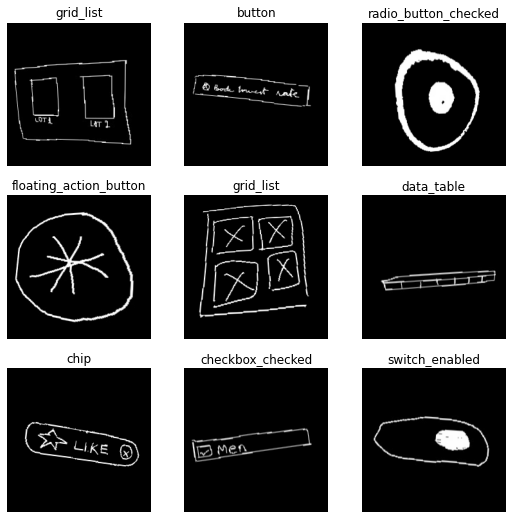

In [9]:
transforms = [*aug_transforms(do_flip=False, pad_mode='border')]

uisketch = DataBlock(blocks=(ImageBlock, CategoryBlock),
                     get_x=ColReader(0, pref=path),
                     get_y=ColReader(1),
                     splitter=TrainTestSplitter(test_size=0.1, random_state=SEED, stratify=train_df.label.values),
                     item_tfms=[InvertImage()],
                     batch_tfms=[*transforms, Normalize.from_stats(*imagenet_stats)],
                    )

dataloaders = uisketch.dataloaders(train_df, num_workers=1)

dataloaders.show_batch()

In [18]:
for inp in dataloaders.train:
    pass

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.92 GiB total capacity; 9.89 GiB already allocated; 3.00 MiB free; 10.19 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# ResNet 152 model

Load the pretrained weights from UISketch paper

In [10]:
learn = cnn_learner(dataloaders,
                    resnet152,
                    metrics=[accuracy, top_k_accuracy])

In [11]:
learn.load("uisketch_pretrained", strict=False) # As we are loading model from FastAI v1 to v2, 
                                                # we are setting strict to False

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


In [13]:
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

1


RuntimeError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 10.92 GiB total capacity; 9.85 GiB already allocated; 23.00 MiB free; 10.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Training

In [14]:
learn = cnn_learner(dataloaders,
                    resnet152,
                    metrics=[accuracy, top_k_accuracy])

learn.load("uisketch_pretrained", strict=False)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.92 GiB total capacity; 9.89 GiB already allocated; 3.00 MiB free; 10.19 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [14]:
learn.fit_one_cycle(6, lr_max=3e-4)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.369199,0.270622,0.914035,0.994737,03:02
1,0.310875,0.249594,0.918713,0.994737,02:58
2,0.312114,0.227397,0.930994,0.995906,02:58
3,0.249565,0.223775,0.925146,0.995906,02:58
4,0.238192,0.220608,0.928070,0.996491,02:58
5,0.214540,0.223763,0.926316,0.995322,02:58


In [15]:
learn.save("uisketch-resnet-152")

Path('models/uisketch-resnet-152.pth')

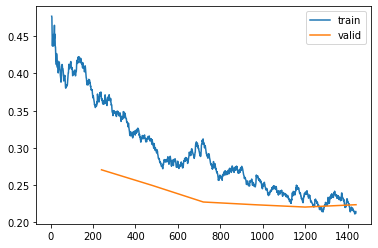

In [16]:
learn.recorder.plot_loss()

## Validation Report

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

KeyboardInterrupt: 

In [18]:
interp.print_classification_report()

                        precision    recall  f1-score   support

                 alert       0.80      0.84      0.82        76
                button       0.80      0.83      0.81        92
                  card       0.84      0.83      0.83        82
      checkbox_checked       0.98      0.97      0.97        87
    checkbox_unchecked       0.94      0.97      0.95        87
                  chip       0.89      0.70      0.78        79
            data_table       0.96      0.97      0.97        78
         dropdown_menu       0.95      0.92      0.93        77
floating_action_button       0.99      0.95      0.97        81
             grid_list       0.95      0.99      0.97        77
                 image       0.96      0.97      0.96        88
                 label       0.95      0.98      0.97        86
                  menu       0.89      0.92      0.91        78
  radio_button_checked       0.96      1.00      0.98        78
radio_button_unchecked       0.98      

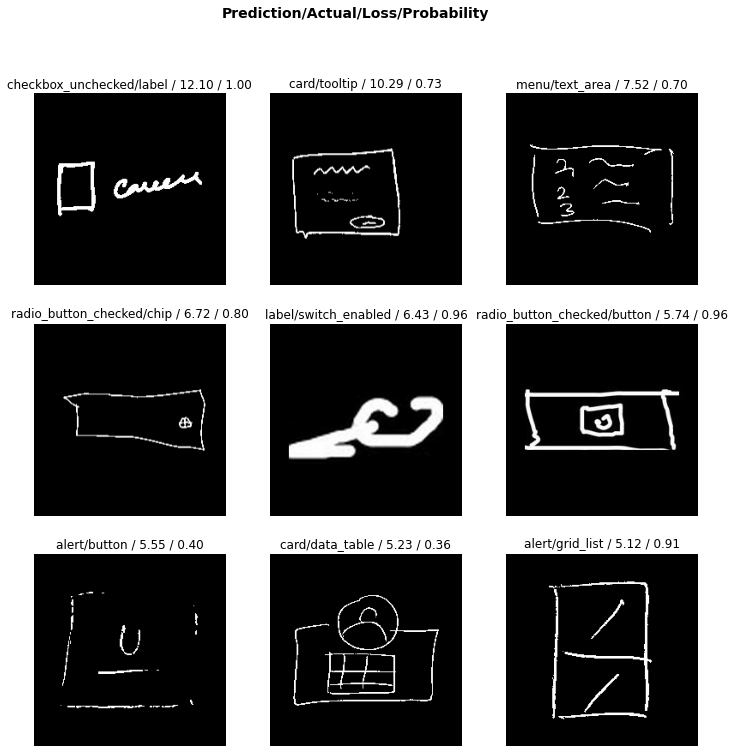

In [19]:
interp.plot_top_losses(9, figsize=(12,12))

# Evaluation

In [20]:
test_dataloader = dataloaders.test_dl(test_df, with_labels=True)

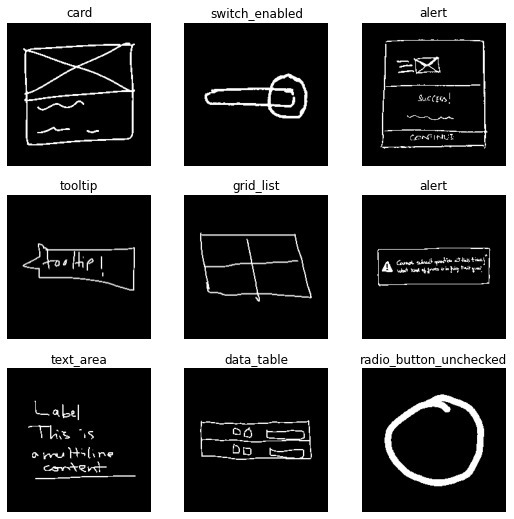

In [21]:
test_dataloader.show_batch()

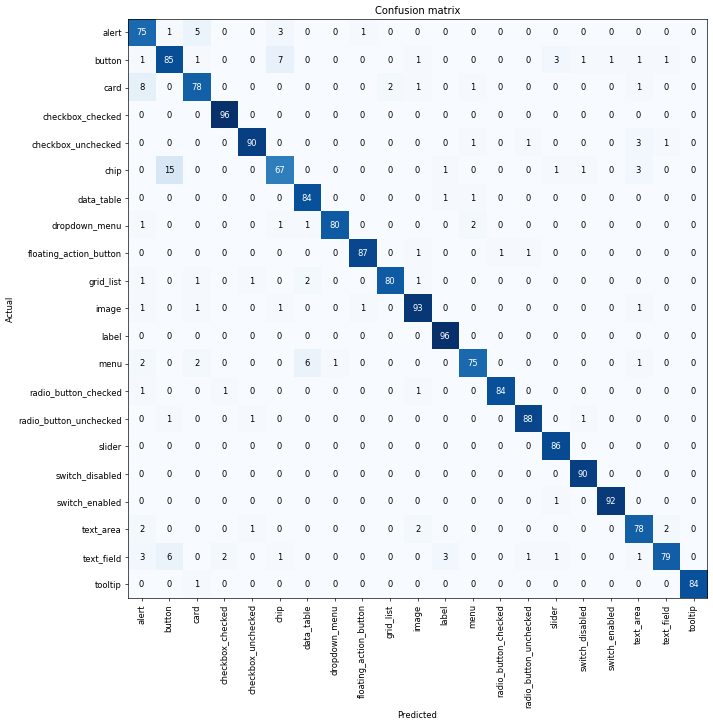

In [22]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dataloader)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
preds = interp.preds
y = interp.targs

tka = top_k_accuracy(preds, y)
print(f"Top K Accuray: {tka}")

acc = accuracy(preds, y)
print(f"Accuracy : {acc}")

Top K Accuray: 0.996842086315155
Accuracy : 0.9300000071525574


In [24]:
interp.print_classification_report()

                        precision    recall  f1-score   support

                 alert       0.79      0.88      0.83        85
                button       0.79      0.83      0.81       102
                  card       0.88      0.86      0.87        91
      checkbox_checked       0.97      1.00      0.98        96
    checkbox_unchecked       0.97      0.94      0.95        96
                  chip       0.84      0.76      0.80        88
            data_table       0.90      0.98      0.94        86
         dropdown_menu       0.99      0.94      0.96        85
floating_action_button       0.98      0.97      0.97        90
             grid_list       0.98      0.93      0.95        86
                 image       0.93      0.95      0.94        98
                 label       0.95      1.00      0.97        96
                  menu       0.94      0.86      0.90        87
  radio_button_checked       0.99      0.97      0.98        87
radio_button_unchecked       0.97      

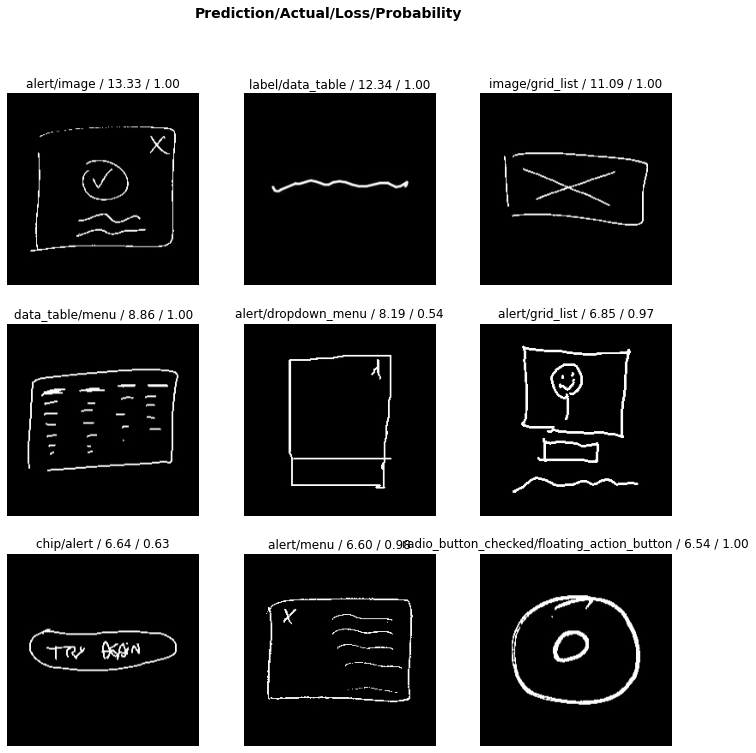

In [25]:
interp.plot_top_losses(9, figsize=(12,12))